In [174]:
from file_processors import histogram_reader, table_writer
from feature_generators import ae_extractor, pca_extractor, tsne_embedder, dbscan_clusterer, knn_finder
from plotters import embedding_plotter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from IPython.display import display, clear_output
from ipywidgets import widgets, HBox, VBox, Layout
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.neighbors import NearestNeighbors
from astroquery.gaia import Gaia
plt.style.use('steven-space.mplstyle')

# Define file paths
data_path = "../datasets"
encoders_path = "../encoders"
properties_file = f"{data_path}/properties-input-Full.csv"
properties_all_file = f"{data_path}/properties-all-columns.csv"
xmatch_file = f"{data_path}/xmatch.csv"
ae_model_2d = f"{encoders_path}/XAE-ENCODER-2D-CNN-cn[32, 16]-fc[192, 48]-neck12-lr0.001-b1024-reg0.0-botreg0.1-kernhe_normal-xae-rs505.h5"
ae_model_3d = f"{encoders_path}/XAE-ENCODER-3D-FC-fc[1536, 384, 96]-neck24-lr0.001-b1024-reg0.1-xae24.h5"

In [5]:
# Widgets
int_text_layout = Layout(width='159px')
histogram_representation_widget = widgets.Dropdown(
    options=["2D", "3D"],
    value="2D",
    description="Histogram Representation:",
    disabled=False,
    style={'description_width': 'initial'}
)

feature_extractor_widget = widgets.Dropdown(
    options=["PCA", "AE"],
    value="PCA",
    description="Feature Extractor:",
    disabled=False,
    style={'description_width': 'initial'}
)

n_pca_widget = widgets.IntSlider(
    value=2, min=2, max=100, step=1, 
    description="PCA Components:", 
    disabled=False, continuous_update=False, 
    readout=True, readout_format='d',
    style={'description_width': 'initial'}
)

latent_size_message = widgets.HTML(
    value="",
    placeholder='',
    description="AE Components:",disabled=False, 
    style={'description_width': 'initial'}
)

tsne_perp_widget = widgets.IntText(
    value=30, description="Perplexity:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_lr_widget = widgets.IntText(
    value=100, description="Learning Rate:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_iter_widget = widgets.IntText(
    value=2000, description="Iterations:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_rs_widget = widgets.IntText(
    value=11, description="Random State:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_ee_widget = widgets.IntText(
    value=1, description="Early Exaggeration:", 
    disabled=False, style={'description_width': 'initial'},
    layout=int_text_layout
)

tsne_init_widget = widgets.Dropdown(
    options=["random", "pca"], value="random", 
    description="Initialization:", disabled=False, 
    style={'description_width': 'initial'},
    layout=int_text_layout
)

# Container for t-SNE widgets
tsne_widgets_container = HBox([tsne_perp_widget, tsne_lr_widget, tsne_iter_widget, tsne_rs_widget, tsne_ee_widget, tsne_init_widget])

# Modify the container to include the n_pca_widget and the text message
widgets_container = HBox([histogram_representation_widget, feature_extractor_widget, n_pca_widget, latent_size_message])


# Event handler for changes in both histogram representation and feature extractor
def on_selection_change(change):
    # Clear previous output
    clear_output(wait=True)
    display(widgets_container)
    display(tsne_widgets_container)

    # Extract the current selections
    histogram_representation = histogram_representation_widget.value
    feature_extractor = feature_extractor_widget.value

    # Set default values for n_pca_widget based on histogram representation
    if histogram_representation == '2D':
        n_pca_widget.value = 15
    elif histogram_representation == '3D':
        n_pca_widget.value = 22

    # Set default values for t-SNE widgets based on both selections
    if feature_extractor == 'PCA':
        n_pca_widget.layout.display = 'flex'  # Show PCA container
        latent_size_message.layout.display = 'none' 
        if histogram_representation == '2D':
            tsne_perp_widget.value = 30
            tsne_lr_widget.value = 80
            tsne_iter_widget.value = 4500
            tsne_rs_widget.value = 11
        elif histogram_representation == '3D':
            tsne_perp_widget.value = 50
            tsne_lr_widget.value = 120
            tsne_iter_widget.value = 3500
            tsne_rs_widget.value = 11
    elif feature_extractor == 'AE':
        n_pca_widget.layout.display = 'none'  # Hide PCA container
        latent_size_message.layout.display = 'flex' 
        if histogram_representation == '2D':
            tsne_perp_widget.value = 40
            tsne_lr_widget.value = 100
            tsne_iter_widget.value = 3000
            tsne_rs_widget.value = 2412
            latent_size_message.value = "12"
        elif histogram_representation == '3D':
            tsne_perp_widget.value = 60
            tsne_lr_widget.value = 180
            tsne_iter_widget.value = 2000
            tsne_rs_widget.value = 12
            latent_size_message.value = "24"

# Attach the event handler to both widgets
histogram_representation_widget.observe(on_selection_change, names='value')
feature_extractor_widget.observe(on_selection_change, names='value')
# Call the handler once to initialize with the current selections
on_selection_change({'new': feature_extractor_widget.value})

In [6]:
# Create name for features 
if feature_extractor_widget.value == "AE":
    name_features = f"{histogram_representation_widget.value}{feature_extractor_widget.value}{latent_size_message.value}"
elif feature_extractor_widget.value == "PCA":
    name_features = f"{histogram_representation_widget.value}{feature_extractor_widget.value}{n_pca_widget.value}"

# Create name for embeddings
name_embedding = f"perp{tsne_perp_widget.value}-lr{tsne_lr_widget.value}-iter{tsne_iter_widget.value}-rs{tsne_rs_widget.value}-ee{tsne_ee_widget.value}-init{tsne_init_widget.value}"

# Select appropriate histogram file
if feature_extractor_widget.value == "PCA":
    if histogram_representation_widget.value == "2D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*none*")[0]
    elif histogram_representation_widget.value == "3D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*none*")[0]
elif feature_extractor_widget.value == "AE":
    if histogram_representation_widget.value == "2D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*minmax*")[0]
    elif histogram_representation_widget.value == "3D":
        histogram_file = glob.glob(f"{data_path}/hist{histogram_representation_widget.value}*minmax*")[0]
print("Selected Histogram Representation File: ", histogram_file)

# Process histogram file and properties table
histograms, df_properties, ids = histogram_reader.histogram_reader(histogram_file,properties_file, feature_extractor_widget.value)

Selected Histogram Representation File:  ../datasets/hist3D-Full-nE16-nt24-ndt16-normnone.pkl


In [90]:
# Extract features from histograms
if feature_extractor_widget.value == "PCA":
        features = pca_extractor.pca_extractor(histograms, int(n_pca_widget.value))
elif feature_extractor_widget.value == "AE":
    if histogram_representation_widget.value == "2D":
        features = ae_extractor.ae_extractor(histograms, ae_model_2d)
    elif histogram_representation_widget.value == "3D":
        features = ae_extractor.ae_extractor(histograms, ae_model_3d)

# Create t-SNE embedding and save it to a file
embedding = tsne_embedder.tsne_embedder(features, perplexity=tsne_perp_widget.value, learning_rate=tsne_lr_widget.value, early_exaggeration=tsne_ee_widget.value, iterations=tsne_iter_widget.value, random_state=tsne_rs_widget.value, dimensions=2, init=tsne_init_widget.value)
tsne_file_name = f"{data_path}/tsne_{name_features}_{name_embedding}.csv"
df_tsne = table_writer.embedding_writer(embedding, ids)
df_tsne.to_csv(tsne_file_name, index=False)
print("t-SNE embedding saved to: ", tsne_file_name)

t-SNE embedding saved to:  ../datasets/tsne_2DPCA15_perp30-lr80-iter4500-rs11-ee1-initrandom.csv


In [56]:
# Widgets
tsne_files = glob.glob(f"{data_path}/tsne*")
tsne_file_widget = widgets.Dropdown(options=tsne_files, description="t-SNE File:", disabled=False, style={'description_width': 'initial'})
dbscan_eps_widget = widgets.FloatSlider(value=0.5, min=0.1, max=5.0, step=0.05, description="Epsilon:", disabled=False, continuous_update=False, readout=True, readout_format='.2f', style={'description_width': 'initial'})
dbscan_min_samples_widget = widgets.IntSlider(value=5, min=1, max=50, step=1, description="Min Samples:", disabled=False, continuous_update=False, readout=True, readout_format='d', style={'description_width': 'initial'})
dbscan_widget_container = HBox([tsne_file_widget, dbscan_eps_widget, dbscan_min_samples_widget])

# Event handler for changes in both histogram representation and feature extractor
def on_selection_change2(change):
    # Clear previous output
    clear_output(wait=True)
    display(dbscan_widget_container)

    # Extract the current selections
    tsne_file = tsne_file_widget.value

    # Set default values for n_pca_widget based on histogram representation
    if "2DPCA" in tsne_file:
        dbscan_eps_widget.value = 2.1
        dbscan_min_samples_widget.value = 22
    elif "3DPCA" in tsne_file:
        dbscan_eps_widget.value = 1.65
        dbscan_min_samples_widget.value = 28
    elif "2DAE" in tsne_file:
        dbscan_eps_widget.value = 1.6
        dbscan_min_samples_widget.value = 25
    elif "3DAE" in tsne_file:
        dbscan_eps_widget.value = 1.9
        dbscan_min_samples_widget.value = 24

# Attach the event handler to both widgets
tsne_file_widget.observe(on_selection_change2, names='value')
# Call the handler once to initialize with the current selections
on_selection_change2({'new2': tsne_file_widget.value})

In [57]:
# Load t-SNE file
df_tsne = pd.read_csv(tsne_file_widget.value)

# Cluster embeddings with DBSCAN and save it to a file
cluster_labels = dbscan_clusterer.dbscan_clusterer(df_tsne, epsilon=dbscan_eps_widget.value, min_samples=dbscan_min_samples_widget.value)
df_dbscan = table_writer.clustering_writer(df_tsne, cluster_labels)
name_clustering = f"eps{dbscan_eps_widget.value}-ms{dbscan_min_samples_widget.value}"
dbscan_file_name = f"{tsne_file_widget.value[:-4]}_{name_clustering}.csv"
dbscan_file_name = dbscan_file_name.replace("tsne", "dbscan")
df_dbscan.to_csv(dbscan_file_name, index=False)

In [58]:
df_properties_full = pd.read_csv(properties_file)

# Widgets
dbscan_files = glob.glob(f"{data_path}/dbscan*")
dbscan_file_widget = widgets.Dropdown(options=dbscan_files, description="DBSCAN File:", disabled=False, style={'description_width': 'initial'})
color_code_options = ["clusters"]
color_code_options.extend(list(df_properties_full.columns[2:]))
colorcode_property_widget = widgets.Dropdown(options=color_code_options, description="Property:", disabled=False, style={'description_width': 'initial'})

bonafide_folder = f"../bonafide_anomalies"
flare_files = list(glob.glob(f"{bonafide_folder}/*flares*.json"))
flare_files.append(None)
dip_files = list(glob.glob(f"{bonafide_folder}/*dips*.json"))
dip_files.append(None)
others_files = list(glob.glob(f"{bonafide_folder}/*others*.json"))
others_files.append(None)

flares_widget = widgets.Dropdown(options=flare_files, value = flare_files[1], description="Bonafide Flares Files:", disabled=False, style={'description_width': 'initial'})
dips_widget = widgets.Dropdown(options=dip_files, value = dip_files[1], description="Bonafide Dips Files:",disabled=False,style={'description_width': 'initial'})
others_widget = widgets.Dropdown(options=others_files, value = others_files[1], description="Bonafide Others Files:",disabled=False,style={'description_width': 'initial'})

plot_widget_container = HBox([dbscan_file_widget, colorcode_property_widget])
bonafide_widget_container = HBox([flares_widget, dips_widget, others_widget])
display(plot_widget_container)
display(bonafide_widget_container)

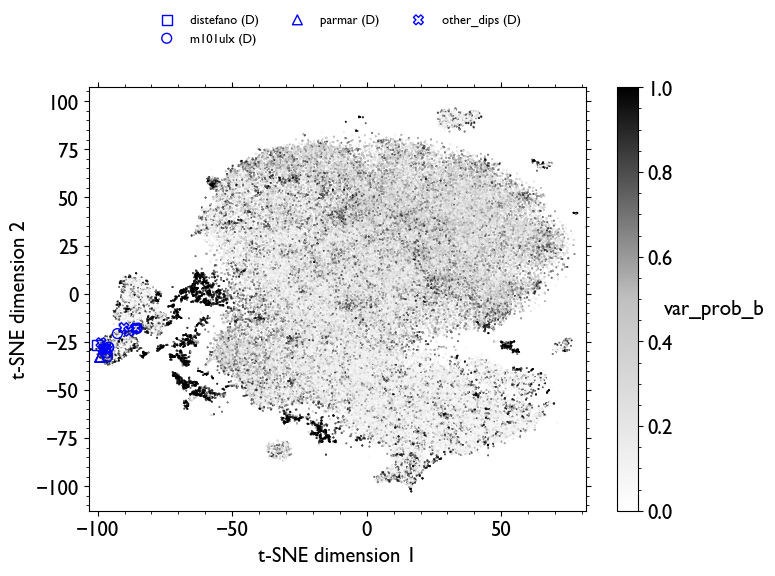

In [112]:
# Load DBSCAN 
df_dbscan = pd.read_csv(dbscan_file_widget.value)
ids = df_dbscan['obsreg_id'].unique()

# Plot embedding
cluster_labels, df_bonafide_dips, df_bonafide_flares, df_bonafide_others, df_bonafide_all = embedding_plotter.embedding_plotter(df_dbscan, df_properties_full, colorcode_property_widget.value, flares_widget.value, dips_widget.value, others_widget.value)

In [95]:
df_bonafide_all

,tsne1,tsne2,obsreg_id,cluster
16962,21.063580,-91.174835,13814_567,7
69326,64.680750,53.484283,4733_229,2
69417,70.233925,59.055270,4736_81,2
69430,63.965816,58.855198,4737_74,2
71660,69.816100,58.680607,5300_95,2
71759,70.294410,58.549330,5322_229,2
75806,61.261852,60.992490,6152_81,2
75894,70.053700,57.799732,6170_74,2
2436,73.823190,55.804077,10783_10,2
2882,74.075200,56.949333,10871_10,2


In [100]:
# Widget
knn_list = np.arange(1, 201, 1).tolist()
cluster_list = tuple(cluster_labels)
knn_widget = widgets.Dropdown(options=knn_list, value=50, description="kNN:", disabled=False, style={'description_width': 'initial'})
cluster_widget = widgets.SelectMultiple(options=cluster_list, value=(), description="Clusters:", disabled=False, style={'description_width': 'initial'})
display(HBox([knn_widget, cluster_widget]))

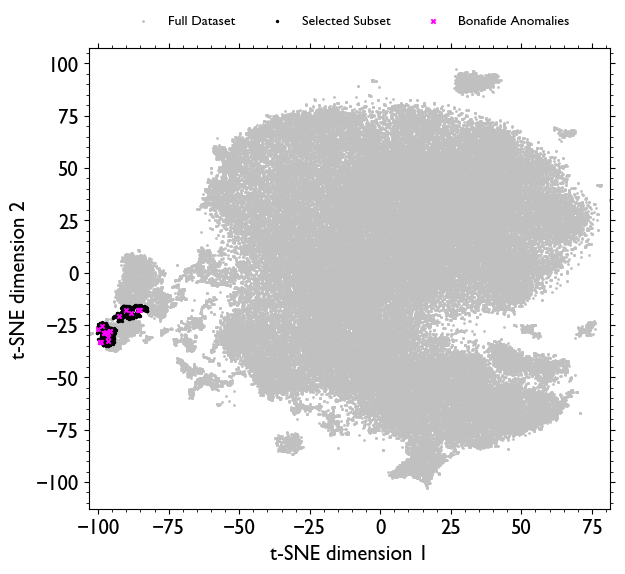

Saving results to:  ../datasets/results_3DPCA22_perp50-lr120-iter3500-rs11-ee1-initrandom-PAPER_eps1.65-ms28.csv_flareNO_dipYES_othersNO_knn100_clusters().csv


In [113]:
clusters_selected = np.array(cluster_widget.value)-1
df_knn = knn_finder.knn_finder(df_bonafide_all, df_dbscan, knn_widget.value)
df_clusters = df_dbscan[df_dbscan['cluster'].isin(cluster_widget.value)]
df_results = pd.concat([df_knn, df_clusters]).drop_duplicates().reset_index()
embedding_plotter.embedding_plotter2(df_dbscan, df_results, df_bonafide_all)

if flares_widget.value != None:
    flare_string = "YES"
else:
    flare_string = "NO"
if dips_widget.value != None:
    dip_string = "YES"
else:
    dip_string = "NO"
if others_widget.value != None:
    others_string = "YES"
else:
    others_string = "NO"
    
save_result_name = f"{dbscan_file_widget.value}_flare{flare_string}_dip{dip_string}_others{others_string}_knn{knn_widget.value}_clusters{cluster_widget.value}.csv"
save_result_name = save_result_name.replace("dbscan", "results")
df_results.to_csv(save_result_name, index=False)
print("Saving results to: ", save_result_name)

In [98]:
# Combine results
df_properties_all = pd.read_csv(properties_all_file)
# Widgets
results_files = glob.glob(f"{data_path}/results*")
results_file_widget = widgets.SelectMultiple(options=results_files, value=(), description="Results Files:", disabled=False, style={'description_width': 'initial'},layout=Layout(width='600px'))
var_options = df_properties_all['var_index_b'].dropna().unique().tolist()
var_options.sort()
var_filter_widget = widgets.Dropdown(options=var_options, value=var_options[0], description="Filter var_index_b >=", disabled=False, style={'description_width': 'initial'})
display(HBox([results_file_widget, var_filter_widget]))

input_widget = widgets.Text(value="BLANK",description="Enter the naming for the candidates selection:",disabled=False,style={'description_width': 'initial'},layout=Layout(width='600px'))
display(HBox([input_widget]))

In [119]:
if len(results_file_widget.value) == 0:
    print("No results file selected!")
else:
    results_list = []
    for i in range(len(results_file_widget.value)):
        df_results = pd.read_csv(results_file_widget.value[i])
        results_list.append(df_results)
    df_candidates = pd.concat(results_list)
    ids = df_candidates['obsreg_id'].unique()
    df_properties_candidates = df_properties_full[df_properties_full['obsreg_id'].isin(ids)]
    df_properties_candidates = df_properties_candidates.drop_duplicates('obsreg_id', keep='first')
    df_properties_candidates = df_properties_candidates[df_properties_candidates['var_index_b'] >= var_filter_widget.value]
    candidates_name = f"{data_path}/candidates_{input_widget.value}_var>={var_filter_widget.value}.csv"
    df_properties_candidates.to_csv(candidates_name, index=False)
    print("Candidates saved to: ", candidates_name)


Candidates saved to:  ../datasets/candidates_DIPS_var>=6.0.csv


In [102]:
df_properties_candidates
len(df_properties_candidates)

4453

In [134]:
candidates_files = glob.glob(f"{data_path}/candidates*")
candidates_file_widget = widgets.Dropdown(options=candidates_files, description="Candidates File:", disabled=False, style={'description_width': 'initial'})
display(candidates_file_widget)

Dropdown(description='Candidates File:', options=('../datasets/candidates_xmatch_DIPS_var>=6.0.csv', '../datas…

In [186]:
# Load candidates file and crossmatch 
df_x = pd.read_csv(xmatch_file,low_memory=False)
df_candidates = pd.read_csv(candidates_file_widget.value)
df_candidates_xmatch = df_candidates.merge(df_x, how='left', left_on='name', right_on='CSC21P_name', suffixes=('', '_xmatch'))
candidates_xmatch_name = candidates_file_widget.value
candidates_xmatch_name = candidates_xmatch_name.replace("candidates", "candidatesxmatch")

xmatch_gaia_ids =  df_candidates_xmatch['GAIA21P_source_id'].dropna().astype(int)
gaia_ids_query = ', '.join(map(str, xmatch_gaia_ids))

query = f"""SELECT 
    source_id, ra, dec, radial_velocity, parallax, bp_rp, phot_g_mean_mag+5*log10(parallax)-10 AS mg
    FROM gaiadr2.gaia_source
    WHERE parallax > 0
    AND source_id IN ({gaia_ids_query})"""

job = Gaia.launch_job(query)
gaia_results = job.get_results()
df_gaia = gaia_results.to_pandas()

df_candidates_xmatch = df_candidates_xmatch.merge(df_gaia, how='left', left_on='GAIA21P_source_id', right_on='source_id', suffixes=('', '_gaia'))
df_candidates_xmatch.to_csv(candidates_xmatch_name, index=False)

In [187]:
final_files = glob.glob(f"{data_path}/candidatesxmatch*")
final_file_widget = widgets.Dropdown(options=final_files, description="Final File:", disabled=False, style={'description_width': 'initial'})
display(final_file_widget)

Dropdown(description='Final File:', options=('../datasets/candidatesxmatch_DIPS_var>=4.0.csv', '../datasets/ca…

In [191]:
df_dinal = pd.read_csv(final_file_widget.value, low_memory=False)
len(df_dinal.columns)
print(df_dinal.columns)

Index(['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1',
       'err_ellipse_ang', 'significance', 'likelihood_class', 'conf_flag',
       'sat_src_flag',
       ...
       'GroupID', 'GroupSize', 'Sep_SPEC_CSC21P', 'source_id', 'ra_gaia',
       'dec_gaia', 'radial_velocity', 'parallax', 'bp_rp', 'mg'],
      dtype='object', length=157)
